In [2]:
from dotenv import load_dotenv
import requests
import pandas as pd
from datetime import datetime, timedelta
import os
import json

In [3]:
load_dotenv()

True

In [ ]:
API_KEY_AGENDA = os.getenv('OPENAGENDA_API_KEY')
AGENDA_UID = "82290100" 
BASE_URL = f"https://api.openagenda.com/v2/agendas/{AGENDA_UID}/events"

In [5]:
# On garde tes coordonnées (Paris) pour filtrer géographiquement DANS cet agenda
LATITUDE = 48.8566
LONGITUDE = 2.3522
RADIUS_KM = 20 # J'ai agrandi un peu pour être sûr d'avoir du monde

In [6]:
DATE_START = (datetime.now() - timedelta(days=365)).strftime("%Y-%m-%d")
DATE_END = (datetime.now() + timedelta(days=365)).strftime("%Y-%m-%d")

In [7]:
def fetch_open_agenda_event():
    """Recuperons les événements depuis un Agenda Spécifique"""
    events_data = []
    
    has_more = True
    
    print(f"Démarrage de la collecte sur l'agenda {AGENDA_UID}...")

    while has_more:
        params = {
            "key": API_KEY_AGENDA,     
            "lat": LATITUDE,
            "lng": LONGITUDE,
            "dist": RADIUS_KM,
            "timings[gte]": DATE_START,
            "timings[lte]": DATE_END,
            "detailed": 1,
        }
        
        try:
            response = requests.get(BASE_URL, params=params)
                
            response.raise_for_status()
            data = response.json()

            # L'API renvoie { "events": [...], "after": ... } ou juste une liste
            current_events = data.get("events", [])

            if not current_events:
                print("Plus d'événements trouvés.")
                break

            # Extraction
            for event in current_events:
                title = event.get("title", {}).get('fr', 'Titre inconnu')
                description = event.get("longDescription", {}).get("fr", '')
                if not description:
                    description = event.get("description", {}).get('fr', '')

                location = event.get('location', {})
                timings = event.get("timings", [])
                
                events_data.append({
                    "id": event.get("uid"),
                    "title": title,
                    "description": description,
                    "date_end": timings[0].get("end") if timings else None,
                    "city": location.get("city"),
                    # Pour le POC, on combine tout de suite le texte pour le RAG
                    "text_for_rag": f"Titre: {title}. Description: {description}. Ville: {location.get('city')}"
                })

            print(f"✓ {len(current_events)} événements récupérés (Total: {len(events_data)})")

            # L'API par défaut renvoie 20 items.
            if len(current_events) < 20: 
                has_more = False
            else:
                # L'API renvoie un champ "after" à la fin du JSON pour la page suivante
                after_cursor = data.get("after")
                if after_cursor:
                    # Méthode simple : on incrémente juste l'offset manuellement
                     params['offset'] = len(events_data)
                else:
                    has_more = False # Sécurité
                    
                # NOTE : Si ça boucle à l'infini sur les mêmes données, 
                # c'est que la pagination ne passe pas.
                # Pour le POC, récupérer 20 à 500 événements suffit largement.
                if len(events_data) >= 500:
                    print("Limite de 500 événements atteinte pour le POC.")
                    has_more = False

        except requests.exceptions.RequestException as e:
            print(f"✗ Erreur : {e}")
            break
    
    df = pd.DataFrame(events_data)
    
    if not df.empty:
        # Nettoyage
        df.drop_duplicates(subset=['id'], inplace=True)
        df = df[df['description'].str.len() > 25]
        print(f"✓ Succès ! {len(df)} événements prêts.")
    else:
        print("✗ Aucun événement récupéré.")
        
    return df

In [8]:
df_events = fetch_open_agenda_event()

Démarrage de la collecte sur l'agenda 82290100...
✓ 20 événements récupérés (Total: 20)
✓ 20 événements récupérés (Total: 40)
✓ 20 événements récupérés (Total: 60)
✓ 20 événements récupérés (Total: 80)
✓ 20 événements récupérés (Total: 100)
✓ 20 événements récupérés (Total: 120)
✓ 20 événements récupérés (Total: 140)
✓ 20 événements récupérés (Total: 160)
✓ 20 événements récupérés (Total: 180)
✓ 20 événements récupérés (Total: 200)
✓ 20 événements récupérés (Total: 220)
✓ 20 événements récupérés (Total: 240)
✓ 20 événements récupérés (Total: 260)
✓ 20 événements récupérés (Total: 280)
✓ 20 événements récupérés (Total: 300)
✓ 20 événements récupérés (Total: 320)
✓ 20 événements récupérés (Total: 340)
✓ 20 événements récupérés (Total: 360)
✓ 20 événements récupérés (Total: 380)
✓ 20 événements récupérés (Total: 400)
✓ 20 événements récupérés (Total: 420)
✓ 20 événements récupérés (Total: 440)
✓ 20 événements récupérés (Total: 460)
✓ 20 événements récupérés (Total: 480)
✓ 20 événements ré

In [49]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            20 non-null     int64 
 1   title         20 non-null     object
 2   description   20 non-null     object
 3   date_end      20 non-null     object
 4   city          20 non-null     object
 5   text_for_rag  20 non-null     object
dtypes: int64(1), object(5)
memory usage: 1.1+ KB


In [50]:
df_events.head()

,id,title,description,date_end,city,text_for_rag
0,46859473,Notre-Dame de Lorette fête l'Octave de l'Immac...,**Une messe en l’honneur de la Vierge Marie** ...,2025-12-08T20:00:00+01:00,Paris,Titre: Notre-Dame de Lorette fête l'Octave de ...
1,6830461,Comment Dieu se manifeste t-il à l'homme ? Un ...,Dieu parle et se fait connaître dans l’histoir...,2025-09-29T15:45:00+02:00,Paris,Titre: Comment Dieu se manifeste t-il à l'homm...
2,25870177,Grande Neuvaine à l’Immaculée Conception,**Tous les jours : Chapelet à 18h15**\n\n**Lun...,2025-12-08T20:00:00+01:00,Paris,Titre: Grande Neuvaine à l’Immaculée Conceptio...
3,41950512,Parcours Alpha couple,Comment mettre en place des moments de qualité...,2025-11-03T22:00:00+01:00,Paris,Titre: Parcours Alpha couple. Description: Com...
4,97451263,Concert de l'Avent,"Emmanuel, Dieu avec nous par le chœur Canta Or...",2025-12-15T21:30:00+01:00,Paris,Titre: Concert de l'Avent. Description: Emmanu...


### EDA sur nos données

In [51]:
df_events['text_for_rag'].iloc[1]

"Titre: Comment Dieu se manifeste t-il à l'homme ? Un trimestre de cours. Description: Dieu parle et se fait connaître dans l’histoire des hommes.  \nVous êtes croyant ? La foi vous intrigue ? Que penser des rapports de l’homme avec Dieu ? Nous chercherons comment Dieu se révèle et parle aux hommes dans la création et dans l’histoire, dans l’Ecriture et au cœur de chacun.  \nLe cours est donné par Jocelyne Picard à 13h45 au CIF et par Brigitte Cholvy à 20h par zoom.. Ville: Paris"

In [52]:
from nltk.probability import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [13]:
corpus = ' '.join(df_events['text_for_rag'].astype(str))
print(corpus[:201])
print('-'*200)
print('longueur de notre base de données :', len(corpus))

Titre: Notre-Dame de Lorette fête l'Octave de l'Immaculée Conception du 8 au 15 décembre. Description: **Une messe en l’honneur de la Vierge Marie** du lundi au vendredi à 19h et samedi à 12h

**Prière
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
longueur de notre base de données : 13770


Les 30 mots les plus present dans nos données :
 [('de', 139), ('à', 59), ('et', 52), ('la', 49), ('du', 45), (':', 41), ('les', 33), ('le', 30), ('par', 23), ('Paris', 21), ('Titre:', 20), ('Description:', 20), ('Ville:', 20), ('en', 19), ('dans', 19), ('des', 18), ('est', 17), ('au', 15), ('décembre', 14), ('se', 13), ('Notre-Dame', 11), ('Messe', 10), ('présidée', 10), ('pour', 10), ('un', 10), ('sur', 9), ('Père', 9), ('sa', 9), ('Dieu', 8), ('?', 8)]


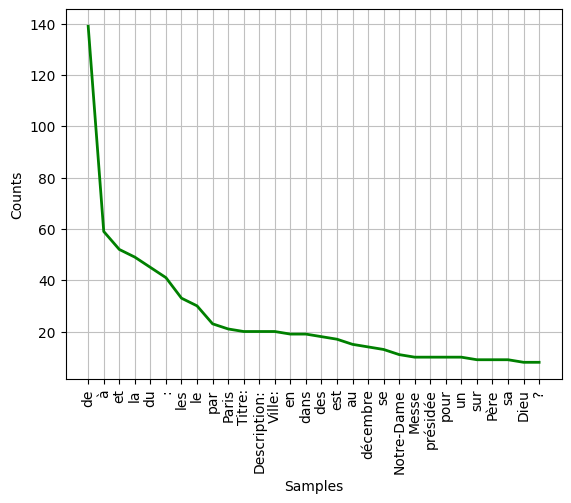

In [14]:
fq = FreqDist(corpus.split())
print('Les 30 mots les plus present dans nos données :\n',fq.most_common(30))
fq.plot(30, cumulative=False, c='g');

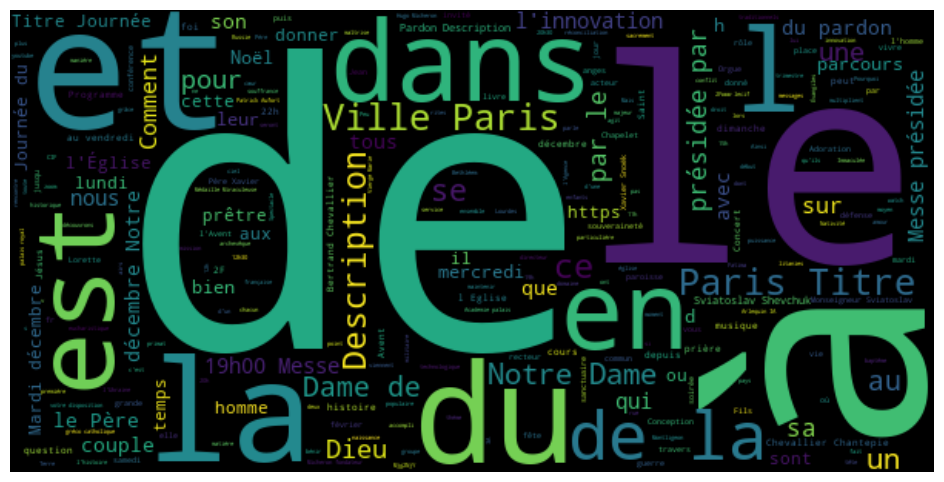

In [15]:
wordcloud = WordCloud(random_state=101, normalize_plurals=True, width=600, height= 300, max_words=300)
wordcloud.generate(corpus)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Construction du R de RAG

In [16]:
# sauvegardons nos données
os.makedirs('../data', exist_ok=True)
df_events.to_csv("../data/events_raw.csv", index=False)

### Vectorisatin de nos données

In [53]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [ ]:
# transformons nos données en documents langchian Document (page_content, metadonnées)
documents = []
for _,row in df_events.iterrows():
    doc = Document(page_content=row['text_for_rag'], metadata={
        'id': row['id'],
        'title': row['title'],
        'city': row['city'],
        'date_end': row['date_end']
    })
    documents.append(doc)

In [55]:
documents

[Document(metadata={'id': 46859473, 'title': "Notre-Dame de Lorette fête l'Octave de l'Immaculée Conception du 8 au 15 décembre", 'city': 'Paris', 'date_end': '2025-12-08T20:00:00+01:00'}, page_content="Titre: Notre-Dame de Lorette fête l'Octave de l'Immaculée Conception du 8 au 15 décembre. Description: **Une messe en l’honneur de la Vierge Marie** du lundi au vendredi à 19h et samedi à 12h\n\n**Prière des laudes** dans l’église du mardi au vendredi à 7h45 et samedi à 8h\n\n**Angélus et litanies de Lorette** du lundi au vendredi à 12h15 suivie de la messe du jour à 12h30\n\n**Chapelet** du lundi au vendredi à 15h\n\n[**Programme et litanies de Lorette sur le site**](https://www.notredamedelorette.org/wp-content/uploads/2024/11/octave-premiere-page-du-livret-.jpg). Ville: Paris"),
 Document(metadata={'id': 6830461, 'title': "Comment Dieu se manifeste t-il à l'homme ? Un trimestre de cours", 'city': 'Paris', 'date_end': '2025-09-29T15:45:00+02:00'}, page_content="Titre: Comment Dieu se 

In [56]:
# transformons nos différents données en chunks 
splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=120)
chunks = splitter.split_documents(documents)

In [21]:
chunks

[Document(metadata={'id': 46859473, 'title': "Notre-Dame de Lorette fête l'Octave de l'Immaculée Conception du 8 au 15 décembre", 'city': 'Paris', 'date_end': '2025-12-08T20:00:00+01:00'}, page_content="Titre: Notre-Dame de Lorette fête l'Octave de l'Immaculée Conception du 8 au 15 décembre. Description: **Une messe en l’honneur de la Vierge Marie** du lundi au vendredi à 19h et samedi à 12h\n\n**Prière des laudes** dans l’église du mardi au vendredi à 7h45 et samedi à 8h\n\n**Angélus et litanies de Lorette** du lundi au vendredi à 12h15 suivie de la messe du jour à 12h30\n\n**Chapelet** du lundi au vendredi à 15h\n\n[**Programme et litanies de Lorette sur le site**](https://www.notredamedelorette.org/wp-content/uploads/2024/11/octave-premiere-page-du-livret-.jpg). Ville: Paris"),
 Document(metadata={'id': 6830461, 'title': "Comment Dieu se manifeste t-il à l'homme ? Un trimestre de cours", 'city': 'Paris', 'date_end': '2025-09-29T15:45:00+02:00'}, page_content="Titre: Comment Dieu se 

In [57]:
# Transformons maintenant ces chunks en embeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectors = embeddings.embed_documents([chunk.page_content for chunk in chunks])

In [58]:
print(len(vectors))

35


In [59]:
# stockons nos vecteur avec FAISS
os.makedirs('../vectorDB', exist_ok=True)
db = FAISS.from_documents(chunks, embeddings)
db.save_local('../vectorDB')

In [60]:
# test quelque recherches
retriever = db.as_retriever(search_kwargs={"k": 5}) # 5 signifie retourne 5 documents similaire
results = retriever.invoke("Veillée d'adoration à la bougie à Paris")
for r in results:
    print(f"Titre: {r.metadata['title']} | Ville: {r.metadata['city']} | Date: {r.metadata['date_end']}")
    print("Extrait:", r.page_content[:200], "\n")

Titre: Veillée d'adoration à la bougie | Ville: Paris | Date: 2025-12-16T22:00:00+01:00
Extrait: Titre: Veillée d'adoration à la bougie. Description: Mardi 16 décembre 2025 de 21h à 22h

Chapelle Notre Dame de Grâce de Grenelle  
4 rue Fondary  
75015 Paris

Métro Dupleix ou Emile Zola  
Bus : 30 

Titre: Soirée de présentation du livre “Ukraine, 365 jours de souffrance et d'espérance” | Ville: Paris | Date: 2025-12-16T21:00:00+01:00
Extrait: \\- Séance de dédicace de \*\*Monseigneur Sviatoslav Shevchuk\*\* Livre en vente à l'issue du spectacle. \\- Verre de l'amitié. Ville: Paris 

Titre: Parcours Alpha couple | Ville: Paris | Date: 2025-11-03T22:00:00+01:00
Extrait: Poser les bons fondements  
L'art de la communication  
La résolution des conflits  
La puissance du pardon  
L'impact de la famille  
Une sexualité de couple épanouie  
Donner et recevoir de l'amour. 

Titre: Journée du pardon | Ville: Paris | Date: 2025-12-16T22:00:00+01:00
Extrait: Titre: Journée du pardon. Description

## PARTIE G du RAG

In [62]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_mistralai import ChatMistralAI
from langchain_core.runnables import RunnablePassthrough

In [ ]:
# configurons le llm
MISTRAL_API_KEY = os.getenv('MISTRAL_API_KEY')
llm = ChatMistralAI(
    mistral_api_key = MISTRAL_API_KEY,
    model='', # je vais essayé après d'autres modèles
    temperature=0.2
    )

In [64]:
template = """
Tu es un assistant expert en culture.
Utilise les éléments de contexte suivants (événements récents) pour répondre à la question de l'utilisateur.
Si tu ne connais pas la réponse d'après le contexte, dis simplement que tu ne sais pas, n'invente rien.

Contexte :
{context}

Question :
{question}

Réponse utile et bien formulée :
"""
template_V2 = """
Tu es l'assistant virtuel expert de "Puls-Events". Ta mission est de recommander des événements culturels.

Voici les informations sur les événements disponibles (Contexte) :
---------------------
{context}
---------------------

Question de l'utilisateur : 
{question}

CONSIGNES DE RÉPONSE (À RESPECTER IMPÉRATIVEMENT) :
1. Si aucune information dans le contexte ne répond à la question, dis simplement que tu ne sais pas.
2. Ton ton doit être engageant, chaleureux et dynamique.
3. FORMATAGE OBLIGATOIRE :
   - Ne fais PAS de gros paragraphes compacts.
   - Utilise une Liste à puces pour chaque événement.
   - Mets le Titre de l'événement en Gras.
   - Utilise des émojis pour chaque ligne (Date, Lieu, Prix/Détails).
   - Finis par une courte phrase invitante.

Réponse structurée :
"""

In [65]:
def rag_chain(prompt_template, llm, retriever):
    prompt = ChatPromptTemplate.from_template(prompt_template)
    rag_system = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
    )
    return rag_system

In [97]:
# essayons avec une question
query = "Bonjour tu vas bien j'espère, je suis chrétien et je cherche une veillée à Paris"
rag = rag_chain(template_V2, llm, retriever)
response = rag.invoke(query)
print(response.content)

Bonjour ! 😊 Je vais très bien, merci, et j’espère que toi aussi ! Voici une super suggestion pour une veillée à Paris qui devrait te plaire :

- **🌟 Veillée d'adoration à la bougie**
  📅 *Mardi 16 décembre 2025 de 21h à 22h*
  📍 *Chapelle Notre-Dame de Grâce de Grenelle* – 4 rue Fondary, 75015 Paris
  🚇 *Métro : Dupleix ou Émile Zola* / *Bus : 30, 42, 70, 80, 88*
  🕯️ *Une ambiance chaleureuse et spirituelle pour une soirée de prière et de recueillement.*

Un moment parfait pour te ressourcer en cette période de l’Avent ! 🙏✨ Tu veux plus de détails ou d’autres idées ?


In [85]:
query = "Je viens d'arriver à Bordeaux et je cherche une concert pour m'amuser"
response = rag.invoke(query)
print(response.content)

Aucun concert n'est mentionné à Bordeaux dans le contexte fourni. Les événements listés se déroulent tous à **Paris**.


## Evaluation de notre RAG avec RAGAS

In [68]:
from ragas import evaluate, EvaluationDataset
from ragas.metrics import (faithfulness, answer_relevancy, context_recall, context_precision)

* RAGAS évalue notre système RAG en comparant ce que le modèle génère avec ce qui est attendu. Il faut donc 4 types de données :

    - Questions (Q) : Ce sont les requêtes utilisateurs qu'on veux tester. Exemple : “Quels concerts ont lieu à Paris en décembre ?”

    - Données R (retrieved context) : Ce sont les documents/chunks que notre retriever (FAISS) renvoie pour chaque question. Exemple : les descriptions d’événements trouvés par FAISS.

    - Données G (generated answers) : Ce sont les réponses produites par notre LLM (Mistral) en utilisant le contexte R. Exemple : “Le concert de Noël aura lieu à Paris le 16 décembre 2025…”

    - Données de référence (ground truth) : Ce sont les réponses correctes, réelles, que nous définissons manuellement ou que nous savons exactes. Exemple : “Concert de Noël, Paris, 16 décembre 2025, Ensemble vocal de Bailly.”

In [69]:
# Pour évaluer notre système il nous faut des données de references
print(corpus)


Titre: Notre-Dame de Lorette fête l'Octave de l'Immaculée Conception du 8 au 15 décembre. Description: **Une messe en l’honneur de la Vierge Marie** du lundi au vendredi à 19h et samedi à 12h

**Prière des laudes** dans l’église du mardi au vendredi à 7h45 et samedi à 8h

**Angélus et litanies de Lorette** du lundi au vendredi à 12h15 suivie de la messe du jour à 12h30

**Chapelet** du lundi au vendredi à 15h

[**Programme et litanies de Lorette sur le site**](https://www.notredamedelorette.org/wp-content/uploads/2024/11/octave-premiere-page-du-livret-.jpg). Ville: Paris Titre: Comment Dieu se manifeste t-il à l'homme ? Un trimestre de cours. Description: Dieu parle et se fait connaître dans l’histoire des hommes.  
Vous êtes croyant ? La foi vous intrigue ? Que penser des rapports de l’homme avec Dieu ? Nous chercherons comment Dieu se révèle et parle aux hommes dans la création et dans l’histoire, dans l’Ecriture et au cœur de chacun.  
Le cours est donné par Jocelyne Picard à 13h45 

In [98]:
questions = [
    "Quels événements religieux ont lieu à Paris en décembre ?",
    "Y a-t-il un concert de Noël prévu à Paris ?",
    "Quand a lieu la veillée d’adoration à la bougie ?",
    "Quels cours théologiques sont proposés au CIF en décembre ?",
    "Quels événements liés au pardon sont organisés à Paris en décembre ?"
]

ground_truths = [
    "Octave de l'Immaculée Conception, Grande Neuvaine, Veillée d'adoration, Concerts de Noël, Conférences Nicée, Journées du Pardon.",
    "Oui : Concert de Noël par la Maîtrise Notre-Dame, et Concert d’Avent et Noël le 16 décembre.",
    "Mardi 16 décembre 2025, de 21h à 22h.",
    "'Comment Dieu se manifeste t-il à l'homme ?' et 'Pourquoi l'Eglise ?'.",
    "Plusieurs 'Journées du Pardon' (confessions) : le 16 décembre (12h-22h), et d'autres dates (11h-20h, 15h-22h)."
]


In [ ]:
eval_template = """Réponds à la question en te basant uniquement sur le contexte suivant.
Contexte: {context}
Question: {question}
Réponse:"""

rag = rag_chain(eval_template, llm, retriever)


In [100]:
# Recuperons nos contexts et answer
contexts = []
answers = []
for query in questions:
    # ici nous avons la réponse générée par notre RAG
    response = rag.invoke(query)
    answers.append(response.content)
    # contextes récupérés par le retriever
    results = retriever.invoke(query)
    contexts.append([doc.page_content for doc in results])

In [101]:
print(contexts)

[['Titre: Journée du Pardon. Description: Le mardi 16 décembre de 12h à 22h.. Ville: Paris', "Titre: Journée du pardon. Description: Dans l'église de 15h à 22h.. Ville: Paris", "\\\\- Séance de dédicace de \\*\\*Monseigneur Sviatoslav Shevchuk\\*\\* Livre en vente à l'issue du spectacle. \\\\- Verre de l'amitié. Ville: Paris", "Titre: Notre-Dame de Lorette fête l'Octave de l'Immaculée Conception du 8 au 15 décembre. Description: **Une messe en l’honneur de la Vierge Marie** du lundi au vendredi à 19h et samedi à 12h\n\n**Prière des laudes** dans l’église du mardi au vendredi à 7h45 et samedi à 8h\n\n**Angélus et litanies de Lorette** du lundi au vendredi à 12h15 suivie de la messe du jour à 12h30\n\n**Chapelet** du lundi au vendredi à 15h\n\n[**Programme et litanies de Lorette sur le site**](https://www.notredamedelorette.org/wp-content/uploads/2024/11/octave-premiere-page-du-livret-.jpg). Ville: Paris", '**Vendredi 12 décembre : Notre-Dame du Laus**  \n19h00 : Messe présidée par le Pè

In [102]:
print(answers)

["Voici une sélection d'événements religieux passionnants à Paris en décembre ! 🎄✨\n\n- **📖 Soirée de présentation du livre “Ukraine, 365 jours de souffrance et d'espérance”**\n  📅 *Mardi 16 décembre 2025* (21h)\n  📍 *Paris* (lieu précis non communiqué)\n  💡 *Séance de dédicace avec Monseigneur Sviatoslav Shevchuk + verre de l’amitié !*\n\n- **🙏 Journée du pardon**\n  📅 *Mardi 16 décembre 2025* (15h–22h)\n  📍 *Église de Paris* (à préciser)\n  💡 *Un moment de recueillement et de spiritualité.*\n\n- **🕯️ Notre-Dame de Lorette fête l’Octave de l’Immaculée Conception**\n  📅 *Du 8 au 15 décembre 2025* (horaires variables)\n  📍 *Église Notre-Dame de Lorette (Paris)*\n  💡 *Messes, laudes, chapelet et prières en l’honneur de la Vierge Marie.*\n\n- **🌟 Grande Neuvaine à l’Immaculée Conception**\n  📅 *Du 12 au 15 décembre 2025* (plusieurs messes)\n  📍 *Paris* (lieu précis non communiqué)\n  💡 *Avec des invités spéciaux comme le Père Charles Troesch et le recteur de Notre-Dame de Fatima !*\n\nPrê

In [103]:
evaluation_data = []
for i in range(len(questions)):
    evaluation_data.append({
        "user_input": questions[i],        # une seule question
        "response": answers[i],            # la réponse correspondante
        "retrieved_contexts": contexts[i],           # liste des chunks pour cette question
        "reference": ground_truths[i]   # vérité annotée
    })

evaluation_dataset = EvaluationDataset.from_list(evaluation_data)


In [104]:
print(evaluation_dataset[0])

user_input='Quels événements religieux ont lieu à Paris en décembre ?' retrieved_contexts=['Titre: Journée du Pardon. Description: Le mardi 16 décembre de 12h à 22h.. Ville: Paris', "Titre: Journée du pardon. Description: Dans l'église de 15h à 22h.. Ville: Paris", "\\\\- Séance de dédicace de \\*\\*Monseigneur Sviatoslav Shevchuk\\*\\* Livre en vente à l'issue du spectacle. \\\\- Verre de l'amitié. Ville: Paris", "Titre: Notre-Dame de Lorette fête l'Octave de l'Immaculée Conception du 8 au 15 décembre. Description: **Une messe en l’honneur de la Vierge Marie** du lundi au vendredi à 19h et samedi à 12h\n\n**Prière des laudes** dans l’église du mardi au vendredi à 7h45 et samedi à 8h\n\n**Angélus et litanies de Lorette** du lundi au vendredi à 12h15 suivie de la messe du jour à 12h30\n\n**Chapelet** du lundi au vendredi à 15h\n\n[**Programme et litanies de Lorette sur le site**](https://www.notredamedelorette.org/wp-content/uploads/2024/11/octave-premiere-page-du-livret-.jpg). Ville: P

In [105]:
metrics_to_evaluate = [faithfulness, answer_relevancy, context_precision, context_recall]
results = evaluate(
    dataset = evaluation_dataset,
    metrics = metrics_to_evaluate,
    llm = llm, # j'utilise le même llm pour evaleur mon RAG
    embeddings = embeddings, # j'utilises le même modèle d'embeddings que pour mon retriever
)

Evaluating: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


In [106]:
print(results)

{'faithfulness': 0.4873, 'answer_relevancy': 0.7136, 'context_precision': 0.5067, 'context_recall': 0.6667}


In [107]:
results_df = results.to_pandas()
results_df.head()

,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,context_precision,context_recall
0,Quels événements religieux ont lieu à Paris en...,[Titre: Journée du Pardon. Description: Le mar...,Voici une sélection d'événements religieux pas...,"Octave de l'Immaculée Conception, Grande Neuva...",0.454545,0.466095,0.000000,0.333333
1,Y a-t-il un concert de Noël prévu à Paris ?,[Titre: Concert de Noël. Description: Noël est...,"Oh, quelle belle question ! 🎄✨ Oui, il y a un ...",Oui : Concert de Noël par la Maîtrise Notre-Da...,0.533333,0.835446,0.583333,1.000000
2,Quand a lieu la veillée d’adoration à la bougie ?,[Titre: Veillée d'adoration à la bougie. Descr...,Voici les détails pour la **Veillée d'adoratio...,"Mardi 16 décembre 2025, de 21h à 22h.",0.750000,0.886654,1.000000,1.000000
3,Quels cours théologiques sont proposés au CIF ...,[**À l'heure de l'accélération technologique d...,Voici les événements théologiques proposés à P...,'Comment Dieu se manifeste t-il à l'homme ?' e...,0.555556,0.530999,0.000000,0.000000
4,Quels événements liés au pardon sont organisés...,[Titre: Journée du Pardon. Description: Le mar...,Voici les événements liés au pardon organisés ...,Plusieurs 'Journées du Pardon' (confessions) :...,0.142857,0.848782,0.950000,1.000000
